# 02 Simulating a bespoke pack using an LTSpice netlist and custom heat transfer

Now we have seen an example using a generated netlist we will explore a simulation using a pre-generated netlist using LTSpice

In [1]:
!pip install -q git+https://github.com/pybamm-team/liionpack.git@main
import liionpack as lp
import numpy as np
import os
from IPython.display import Image
import networkx as nx
import matplotlib.pyplot as plt
import pybamm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In order to do this we'll use a couple bespoke methods designed to work with the example data provided with the package. There are a few directories where we can find the saved files

In [2]:
lp.DATA_DIR

'c:\\users\\tom\\code\\pybamm_liionpack\\liionpack\\data'

In [3]:
lp.CIRCUIT_DIR

'c:\\users\\tom\\code\\pybamm_liionpack\\liionpack\\circuits'

Using os we can have a look at what's in here

In [4]:
os.listdir(lp.DATA_DIR)

['cfd_data.mat', 'cfd_data.xlsx']

The data directory contains a spreadsheet with the results of some cfd simulations that calculated the heat transfer coefficient for each battery in a test module with air cooling. The simualtion varied the battery temperature and the air flow rate.

In [5]:
os.listdir(lp.CIRCUIT_DIR
        )

['AMMBa',
 'AMMBa.asc',
 'AMMBa.cir',
 'AMMBa.cmp',
 'AMMBa_schem.PNG',
 'AMMBa_terminals.asc',
 'AMMBa_terminals.cir',
 'AMMBa_terminals.cmp']

The circuit directory contains LTSpice circuit diagrams and an exported netlist called 'AMMBa.cir'. For convenience an image is also saved in the file directory

In [6]:
impath = os.path.join(lp.CIRCUIT_DIR, 'AMMBA_schem.png')
print(impath)
local_image = Image(filename=impath)

c:\users\tom\code\pybamm_liionpack\liionpack\circuits\AMMBA_schem.png


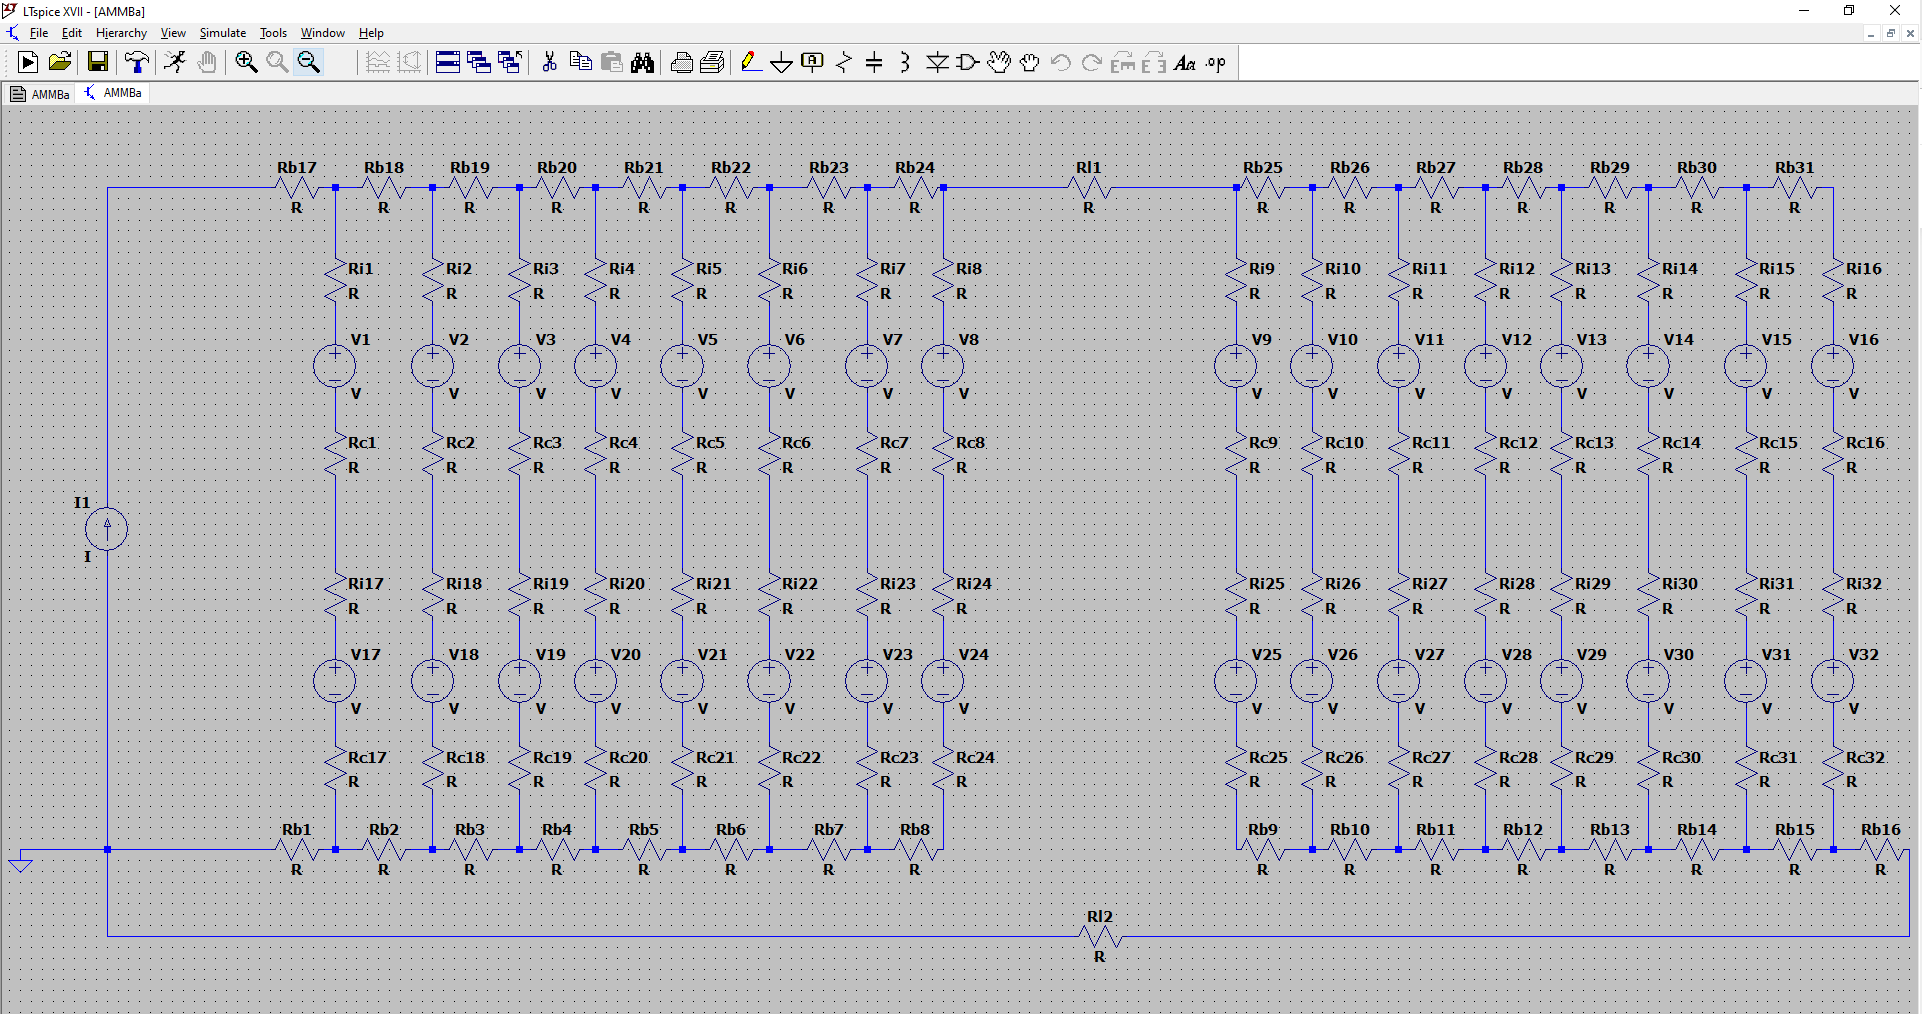

In [7]:
local_image

We can load the netlist using a utility tool provided

In [8]:
netlist = lp.read_netlist('AMMBa.cir')

In [9]:
netlist

,desc,node1,node2,value
0,V1,18,34,4.2000
1,V2,19,35,4.2000
2,V3,20,36,4.2000
3,V4,21,37,4.2000
4,V5,22,38,4.2000
...,...,...,...,...
125,Rc31,96,112,0.0100
126,Rc32,97,113,0.0100
127,I1,0,1,80.0000
128,Rl1,10,9,0.0005


We now have the netlist as a pandas.DataFrame which describes the circuit in a nodal fashion. The first line shows that a voltage source connects nodes 18 and 34 and has initial value 4.2. We can find all the voltage sources by searching the descrition for elements beginning with 'V'. These correspond to the batteries and there are 32 in this example connected in a 16p2S configuration.

In [10]:
V_map = netlist['desc'].str.find('V') > -1

In [11]:
V_map

0       True
1       True
2       True
3       True
4       True
       ...  
125    False
126    False
127    False
128    False
129    False
Name: desc, Length: 130, dtype: bool

In [12]:
sum(V_map)

32

Similarly we can get the current source and resistors

In [13]:
I_map = netlist['desc'].str.find('I') > -1

In [14]:
R_map = netlist['desc'].str.find('R') > -1

The netlist does not provide the spatial information of where the batteries are located in the pack but we can generate a graphical representation using networkx

In [15]:
netlist['node1']

0       18
1       19
2       20
3       21
4       22
      ... 
125     96
126     97
127      0
128     10
129    114
Name: node1, Length: 130, dtype: int32

In [16]:
edge_list = list(zip(netlist['node1'], netlist['node2']))

In [17]:
G = nx.Graph(edge_list)

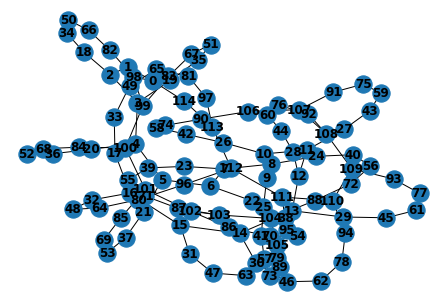

In [18]:
nx.draw(G, with_labels=True, font_weight='bold')

The graph is useful for some things but for visualisation it's better to have the coordinates of the batteries. For this example we need to hard-code them.

In [19]:
X_pos = [0.080052414,0.057192637,0.080052401,0.057192662,0.080052171,0.057192208,0.080052285,0.057192264,
         -0.034260006,-0.011396764,-0.034259762,-0.011396799,-0.034259656,-0.011397055,-0.034259716,-0.01139668,
         0.034329391,0.01146636,0.034329389,0.011466487,0.034329301,0.011466305,0.034329448,0.011465906,
         -0.079983086,-0.057122698,-0.079983176,-0.057123076,-0.079982958,-0.057122401,-0.079982995,-0.057122961]

Y_pos = [-0.046199913,-0.033000108,-0.019799939,-0.0066001454,0.0066000483,0.019799888,0.033000056,0.046200369,
         0.046200056,0.033000127,0.019800097,0.0065999294,-0.0065998979,-0.019800061,-0.032999967,-0.046200222,
         -0.04620005,-0.032999882,-0.019800016,-0.0065999624,0.0065997543,0.019799885,0.033000077,0.046199929,
         0.0462001,0.033000148,0.019800099,0.0066000627,-0.0065999586,-0.019800142,-0.032999927,-0.046199973]

Now we can plot the cells using our customized scatter plot. Here we ar just showing the cell number

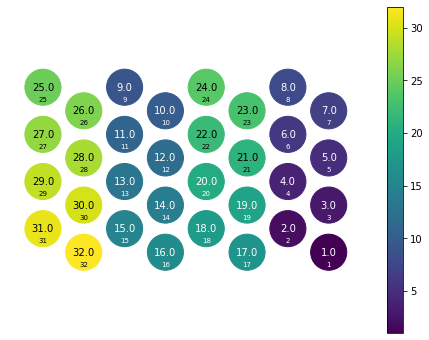

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
data = np.arange(32)+1
lp.cell_scatter_plot(ax, X_pos, Y_pos, c=data)

The pack is being air cooled in the experiment with air flow from left to right. We can use the heat transfer coefficients from the CFD data to simulate this variable cooling as the air reaching the cells on the left will be cooler they will be cooled more effectively. Here we are making use of a bespoke function to read this specific data file and return some plane equations for the relation between temperature, flow-rate and heat transfer coefficient.

In [21]:
data, xv, yv, planes = lp.read_cfd_data()

We can now retrieve the heat transfer coefficient from the cfd data for a given pack cell temperature and cooling flow rate. N.B we can implment this as part of the solve procedure so that htc updates dynamically with individually changing battery temperatures but for now a representative temperature of 25 degrees is chosen for all cells.

In [22]:
lin_htc = lp.get_linear_htc(planes, T=np.ones(32)*25, Q=0.001)

In [23]:
lin_htc

array([ 8.12441928,  7.73555137,  6.43145966,  7.31415773,  6.38507143,
        7.52567209,  6.49903193,  8.67378471, 12.21667125, 10.6049092 ,
       14.25384806, 11.66541894, 13.72184686, 11.09651543, 13.100212  ,
       11.47094721,  9.63635114,  9.37035675,  8.18509052,  9.39528058,
        8.32494898,  9.79334252,  8.28011774,  9.80147257, 17.60894629,
       14.90593104, 20.83404666, 19.25218509, 23.34184288, 17.3792868 ,
       18.72428832, 14.19862206])

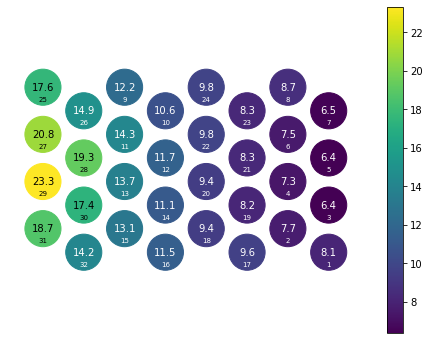

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))
lp.cell_scatter_plot(ax, X_pos, Y_pos, c=lin_htc)

As you can see the htc is clearly dependent on the cell's position in the pack with those closest to the air flow inlet on the left being more strongly cooled.

In [25]:
output_variables = [  
    'X-averaged total heating [W.m-3]',
    'Volume-averaged cell temperature [K]',
    ]
# Cycling protocol
experiment = pybamm.Experiment(
    ["Charge at 50 A for 30 minutes",
     "Rest for 15 minutes",
     "Discharge at 50 A for 30 minutes",
     "Rest for 15 minutes"],
    period="10 seconds",
)
protocol = lp.generate_protocol_from_experiment(experiment)
# PyBaMM parameters
chemistry = pybamm.parameter_sets.Chen2020
parameter_values = pybamm.ParameterValues(chemistry=chemistry)

c:\users\tom\code\pybamm\pybamm\experiments\experiment.py:82: DeprecationWarning: 'parameters' as an input to the Experiment class will soon be deprecated. Please open an issue if you are using this feature.
  warnings.warn(


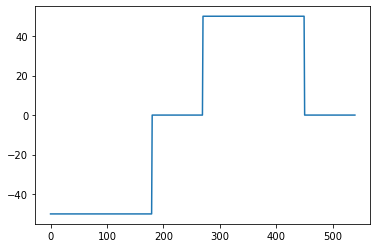

In [26]:
plt.figure()
plt.plot(protocol)

To use the custom heat transfer co-efficients we use the `thermal_simulation` as `sim_func` which is passed in functional format without calling it. We also pass `lin_htc` into the solver as an input for the parameter "Total heat transfer coefficient [W.m-2.K-1]"

In [30]:
sim_func = lp.thermal_simulation
inputs = {"Total heat transfer coefficient [W.m-2.K-1]": lin_htc}

In [31]:
# Solve pack
output = lp.solve(netlist=netlist,
                  sim_func = sim_func,
                  parameter_values=parameter_values,
                  experiment=experiment,
                  output_variables=output_variables,
                  inputs=inputs)

Stepping simulation: 100%|███████████████████████████████████████████████████████████| 540/540 [00:35<00:00, 15.13it/s]


In [32]:
print(output.keys())

dict_keys(['Time [s]', 'Pack current [A]', 'Pack terminal voltage [V]', 'Cell current [A]', 'Terminal voltage [V]', 'Measured battery open circuit voltage [V]', 'X-averaged total heating [W.m-3]', 'Volume-averaged cell temperature [K]'])


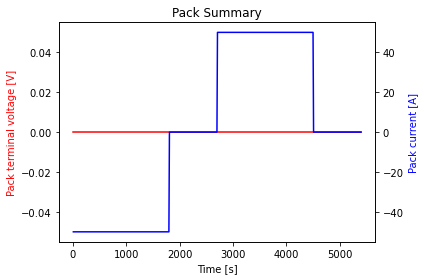

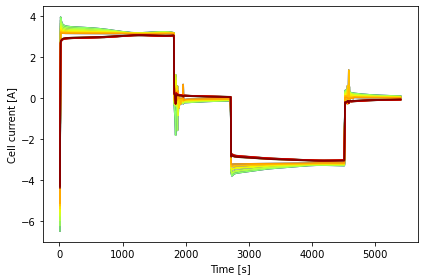

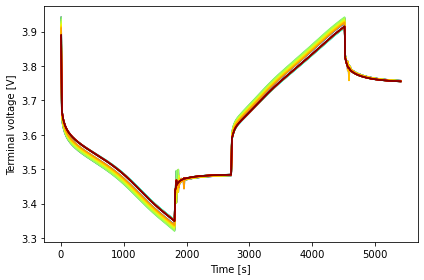

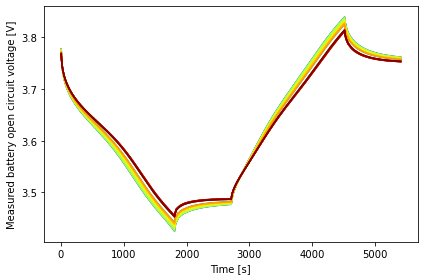

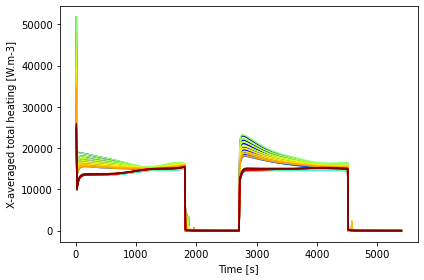

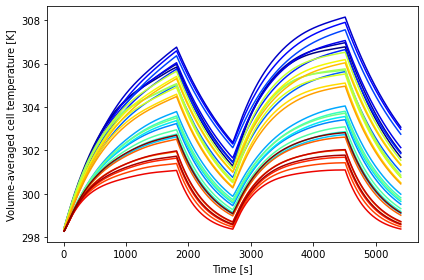

In [33]:
lp.plot_output(output)

In [30]:
Tout = output['Volume-averaged cell temperature [K]']
Tmin = Tout.min()
Tmax = Tout.max()
print('Max Temperature', Tmax)

Max Temperature 308.1437351229108


We have now run the simulation for the bespoke pack design and included bespoke heat transfer coefficients and we have recorded the output temperature. We can visualize this interactively using a widget

In [31]:
def interactive_plot(step):
    fig, ax = plt.subplots(figsize=(8, 6))
    lp.cell_scatter_plot(ax, X_pos, Y_pos, c=Tout[step, :], vmin=Tmin, vmax=Tmax, cmap='inferno')
    plt.title('Cell Temperature')

In [32]:
interact(interactive_plot, step=widgets.IntSlider(min=0, max=Tout.shape[0]-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='step', max=539), Output()), _dom_classes=('widget-intera…

<function __main__.interactive_plot(step)>